# Composite Model Architecture for Information Extraction

This project describes an approach for identifying and quantifying the impact of natural and man-made disasters on stock prices. The methodology involves scraping the web for news articles and stock market data, applying text mining techniques to process and extract relevant information from the articles, and conducting a correlation analysis between the extracted data and stock price movements. Among all the disasters assessed, the Covid-19 pandemic exhibited the strongest correlation with stock prices.

In [ ]:
!python -m spacy download en_core_web_lg

In [1]:
%load_ext autoreload
%autoreload 2

## Dataset Building

The following sections of code demonstrate the methodology we used for building our dataset. The whole process took around 72 hours.
First, we build a dataframe consisting all the URL's to news articles for the specified disasters as query which were published in the country (from the countries list). We then filter them by only considering articles that were published in the US, and then sampling articles to reduce the overall size while maintaining the relative distribution of dates published and query which was used to get the URL

In [2]:
BUILD_DATASET = False

In [3]:
import os
from utils.dataset.build import DatasetBuilder
from utils.dataset.labels import LabelsBuilder
from utils.dataset.download import DatasetDownloader


if BUILD_DATASET:
    disasters = ["earthquake", "flood", "hurricane", "wildfire", "tsunami", "landslide", "volcano", "tornado", "drought",
                "explosion", "fires", "terrorist attack", "plane crash", "train derailment", "oil spill", "building collapse",
                "nuclear accident", "pandemic", "cyber attack", "stock market crash", "power outage", "riots", "protest"]

    countries = ["US", "CH", "TW", "GM", "FR", "UK", "JA", "KS", "IN", "BR"]

    output_dir = os.path.join("data", "news", "links")
    os.makedirs(output_dir, exist_ok=True)

    builder = DatasetBuilder(disasters, countries, output_dir)

    builder.build_news_urls_dataset()
    builder.download_articles(batch_size=500)

    labels = LabelsBuilder()
    labels.build_labels()
else:
    data_dir = os.path.join("data", "articles")
    stocks_dir = os.path.join("data", "stocks")
    print("Downloading dataset...")
    downloader = DatasetDownloader(data_dir, stocks_dir)
    downloader.download()

Download complete


## Loading Dataset

The custom class ArticlesDataset is built to load the dataset in a streaming fashion. It loads the index and labels in memory while streaming the raw content as required. This is a scalable approach since datasets, especially for tasks such as this, only grow in time and one day can reach well into GBs. It is not practical to load the entire dataset in memory for such cases.

Dataset size: 56628
Articles mentioning disaster occuring: 25164
query
pandemic              6347
earthquake            6151
protest               6055
wildfire              6025
riots                 5972
explosion             5723
terrorist attack      5382
cyber attack          5136
oil spill             4718
stock market crash    3257
nuclear accident      1862
Name: count, dtype: int64
date
1546300800    13
1546387200     8
1546473600    21
1546560000     7
1546646400     6
              ..
1743120000    30
1743206400    23
1743292800    28
1743379200    40
1743465600     2
Name: count, Length: 2280, dtype: int64
event_occured
0    31464
1    25164
Name: count, dtype: int64
event
explosion             4850
earthquake            4341
protest               4125
cyber attack          2193
riots                 2152
wildfire              2148
terrorist attack      1952
oil spill             1541
pandemic              1282
stock market crash     379
nuclear accident       201
Name: cou

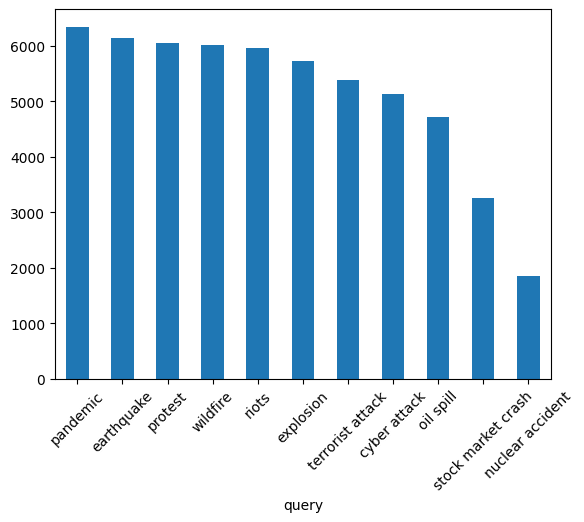

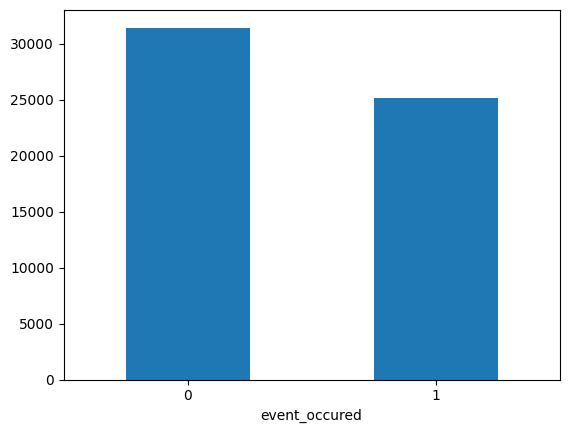

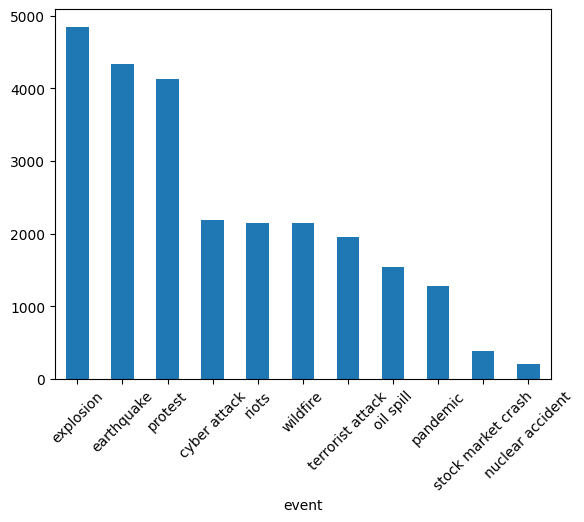

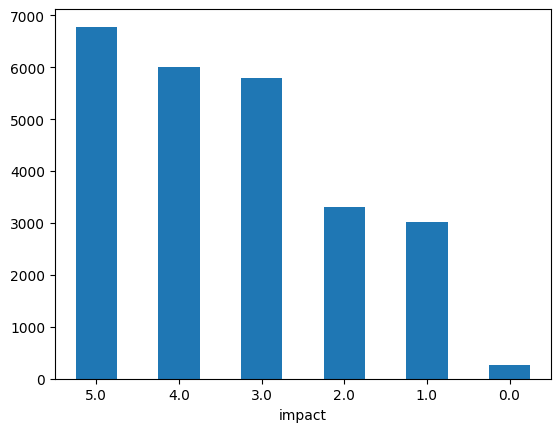

In [4]:
import os
from utils.dataset.articles import ArticlesDataset


DATA_DIR = os.path.join("data", "articles")

dataset = ArticlesDataset(DATA_DIR)
print(f"Dataset size: {len(dataset)}")
articles = dataset.filter_by_label(event_occured=True)
print(f"Articles mentioning disaster occuring: {len(articles)}")
dataset.show_dist(plot=True)

## Dataset Exploration (Ground Truth)

In order to build the ground truth labels for this dataset, we utilized Google's Gemini Pro.

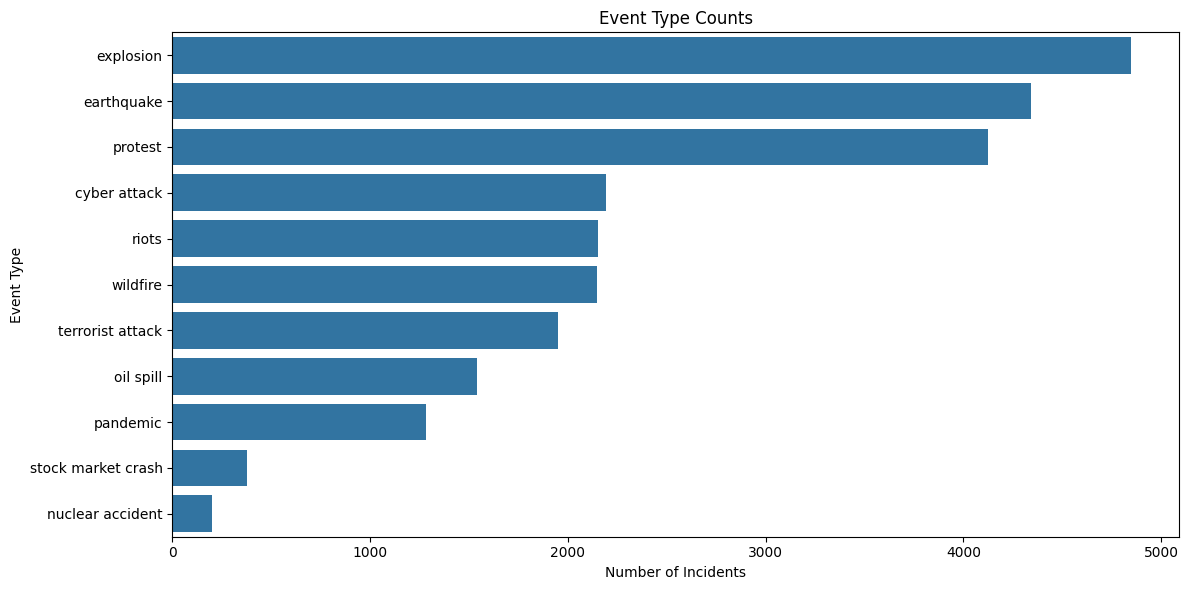

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.countplot(data=articles.filtered_labels, y="event", order=articles.filtered_labels["event"].value_counts().index)
plt.title("Event Type Counts")
plt.xlabel("Number of Incidents")
plt.ylabel("Event Type")
plt.tight_layout()

In [31]:
import folium
from folium.plugins import HeatMap

map_ = folium.Map(location=[20,0], zoom_start=2)
heat_data = articles.filtered_labels[['latitude','longitude','impact']].dropna().values.tolist()
HeatMap(heat_data, radius=8, blur=5, max_zoom=10).add_to(map_)
map_

## Deduplication

Cleaning out noisy articles and aggregate multiple articles of the same disaster into one. More articles means higher confidence that a disaster occurred.

In [8]:
import pandas as pd
from utils.deduplication.deduplicate import Deduplicator


records_df = articles.filtered_labels
deduplicator = Deduplicator(records_df)
deduplicator.deduplicate(spatial_radius=100, temporal_radius=3)
confident_events = deduplicator.get_unique_events(confidence_threshold=0.7)
confident_events

c:\Users\Lakshaya Karthikeyan\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
c:\Users\Lakshaya Karthikeyan\Downloads\Downloads\cs5246-text-mining\utils\deduplication\deduplicate.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["dt"] = pd.to_datetime(self.df["dt"], format="%Y-%m-%d", errors="coerce")
c:\Users\Lakshaya Karthikeyan\Downloads\Downloads\cs5246-text-mining\utils\deduplication\deduplicate.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,event_id,event,dt,impact,latitude,longitude,city,state,country,confidence,n_reports
103,cyber attack_0_43,cyber attack,2020-11-25,5,39.464767,-76.733652,None,Maryland,United States,0.778,6
105,cyber attack_0_45,cyber attack,2021-01-01,3,30.056440,-90.566681,Reserve,Louisiana,United States,0.720,3
150,cyber attack_0_86,cyber attack,2022-08-26,2,43.193852,-71.572395,None,New Hampshire,United States,0.760,4
161,cyber attack_0_96,cyber attack,2023-01-09,3,41.589614,-93.616396,Des Moines,Iowa,United States,0.792,5
165,cyber attack_101_0,cyber attack,2021-07-22,4,-30.559482,22.937506,None,None,South Africa,0.888,8
...,...,...,...,...,...,...,...,...,...,...,...
7653,wildfire_9_83,wildfire,2024-06-01,4,38.794595,-106.534838,None,None,United States,0.720,3
7656,wildfire_9_86,wildfire,2024-06-24,4,38.794595,-106.534838,None,None,United States,0.770,8
7663,wildfire_9_92,wildfire,2024-11-16,3,38.794595,-106.534838,None,None,United States,0.869,9
7667,wildfire_9_96,wildfire,2025-01-07,5,38.794595,-106.534838,None,None,United States,0.903,10


## Disaster Classification

Binary classification of whether the article talks about a disaster occurring or not. A logistic regression model is developed on the labelled dataset with K-Fold Cross Validation with k = 5.

In [4]:
from utils.disaster_classification.classify import DisasterClassifier


classifier = DisasterClassifier(dataset, k_fold=5)
train_losses, train_accuracies, val_losses, val_accuracies = classifier.train()

Loaded X: (56628, 384)
Loaded Y: (56628,)


Training:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

Fold 1: Train Loss=0.4442, Train Acc=0.8009, Val Loss=0.4530, Val Acc=0.7970


Training:  40%|████      | 2/5 [00:05<00:07,  2.54s/it]

Fold 2: Train Loss=0.4444, Train Acc=0.8011, Val Loss=0.4526, Val Acc=0.7960


Training:  60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

Fold 3: Train Loss=0.4456, Train Acc=0.8015, Val Loss=0.4509, Val Acc=0.7942


Training:  80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

Fold 4: Train Loss=0.4431, Train Acc=0.8007, Val Loss=0.4588, Val Acc=0.7935


Training: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]

Fold 5: Train Loss=0.4467, Train Acc=0.7990, Val Loss=0.4429, Val Acc=0.8040
Mean Train Loss=0.4448, Mean Train Acc=0.8006, Mean Val Loss=0.4516, Mean Val Acc=0.7969
Finished Model Training
Saved model
Testing Model
Test Loss=0.4389, Test Acc=0.8069


## Event Extraction

 To extract event categories from article titles, we employ an unsupervised topic modeling approach using Latent Dirichlet Allocation (LDA).

In [30]:
from utils.event_extraction.lda import LDA


lda = LDA(articles)
lda.build_model()
lda.df

[nltk_data] Downloading package punkt to C:\Users\Lakshaya
[nltk_data]     Karthikeyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Lakshaya
[nltk_data]     Karthikeyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Lakshaya
[nltk_data]     Karthikeyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Lakshaya
[nltk_data]     Karthikeyan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pre-processing dataset...


Building corpus: 100%|██████████| 25164/25164 [00:00<00:00, 239669.07it/s]


Loaded LDA Model
Running inference...


Running inference: 100%|██████████| 25164/25164 [00:02<00:00, 12312.58it/s]


,index_id,title,event,tokens,extracted_event
0,1,Evacuation Orders in Place Amid Massive South ...,wildfire,"[evacuation, order, amid, massive, carolina, w...",5
1,2,Wildfires prompt evacuations in Cumberland Cou...,wildfire,"[wildfire, prompt, evacuation, cumberland, fai...",5
2,3,Active NC wildfires burning 600 acres in four ...,wildfire,"[active, wildfire, burning, acre, forest]",5
3,7,Wildfire burns at Wharton State Forest in Sout...,wildfire,"[wildfire, burn, wharton, forest, jersey, nbc,...",5
4,11,Safety tips as smoky conditions persist near C...,wildfire,"[tip, smoky, condition, persist, carolina, for...",6
...,...,...,...,...,...
25159,56606,How to check and protect your information online,cyber attack,[protect],1
25160,56616,Marriott to rename loyalty program after cyber...,cyber attack,"[marriott, rename, loyalty, cyber]",6
25161,56618,National Guard called in after city of Akron t...,cyber attack,"[guard, akron, targeted, cyber]",6
25162,56619,"Dems allege they were hacked , likely by Russi...",cyber attack,"[dems, allege, hacked, russian, intel, midterm]",4


In [31]:
lda.generate_topic_labels()

Generating topics...


{0: 'earthquake (0.22), magnitude (0.11), strike (0.04), hit (0.04), california (0.03)',
 1: 'terrorist (0.03), stock (0.02), shooting (0.02), crash (0.02), border (0.02)',
 2: 'plant (0.04), kill (0.04), rattle (0.03), russian (0.03), ukraine (0.03)',
 3: 'coronavirus (0.05), damage (0.03), victim (0.03), hong (0.02), kong (0.02)',
 4: 'explosion (0.16), injured (0.03), pandemic (0.03), gas (0.03), covid (0.02)',
 5: 'wildfire (0.09), update (0.02), evacuation (0.02), acre (0.02), burn (0.02)',
 6: 'oil (0.09), spill (0.07), cyber (0.07), quake (0.06), beach (0.01)',
 7: 'protest (0.13), riot (0.05), protester (0.03), capitol (0.02), rally (0.01)'}

In [32]:
topic_to_event_name = lda.generate_topic_labels_from_top2(lda.lda_model)
lda.df['extracted_event_name'] = lda.df['extracted_event'].map(topic_to_event_name)
lda.df['label_fuzzy_match'] = lda.df.apply(
    lambda row: lda.is_set_match_partial(row['event'], row['extracted_event_name']),
    axis=1
)

In [49]:
accuracy = len(lda.df[lda.df.label_fuzzy_match] == True)/len(lda.df)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 57.27%


In [34]:
lda.df.head()

,index_id,title,event,tokens,extracted_event,extracted_event_name,label_fuzzy_match
0,1,Evacuation Orders in Place Amid Massive South ...,wildfire,"[evacuation, order, amid, massive, carolina, w...",5,wildfire + update,True
1,2,Wildfires prompt evacuations in Cumberland Cou...,wildfire,"[wildfire, prompt, evacuation, cumberland, fai...",5,wildfire + update,True
2,3,Active NC wildfires burning 600 acres in four ...,wildfire,"[active, wildfire, burning, acre, forest]",5,wildfire + update,True
3,7,Wildfire burns at Wharton State Forest in Sout...,wildfire,"[wildfire, burn, wharton, forest, jersey, nbc,...",5,wildfire + update,True
4,11,Safety tips as smoky conditions persist near C...,wildfire,"[tip, smoky, condition, persist, carolina, for...",6,oil + spill,False


## Location Extraction

In the context of stock market analysis, understanding the geographical grounding of news articles is critical for attributing market movements to real-world events. 
To address this, we developed a location extraction pipeline designed to robustly infer the cities, states, and countries mentioned in each news article. The code utilizes a mixture of methods, from named entity recognition to more intricate extraction techniques.

In [4]:
from utils.location_extraction.extract import LocationExtractor


extractor = LocationExtractor(articles)
city_accuracy, state_accuracy, country_accuracy = extractor.build()
print(f"\tCity Accuracy: {city_accuracy*100:.2f}%\n\tState Accuracy: {state_accuracy*100:.2f}%\n\tCountry Accuracy: {country_accuracy*100:.2f}%")

Building dataframe...


Extracting locations: 100%|██████████| 25164/25164 [1:20:18<00:00,  5.22it/s]  


	City Accuracy: 45.46%
	State Accuracy: 47.77%
	Country Accuracy: 69.21%


In [5]:
extractor.df

,id,index_id,url,title,date,country,query,offset,length,id,...,loc,city,state,country,latitude,longitude,content,extracted_city,extracted_state,extracted_country
0,2,1,https://www.newsweek.com/south-north-carolina-...,Evacuation Orders in Place Amid Massive South ...,1740873600,US,wildfire,7883,4821,2,...,"North Carolina, USA",None,North Carolina,United States,35.759573,-79.019300,"Based on facts, either observed and verified f...",None,south carolina,united states
1,3,2,https://fox17.com/news/local/wildfires-prompt-...,Wildfires prompt evacuations in Cumberland Cou...,1741132800,US,wildfire,12704,2331,3,...,"Middle Tennessee, USA",None,Tennessee,United States,35.517491,-86.580447,Wildfires have broken out in Middle Tennessee ...,Fairfield Glade,Rhode Island,united states
2,4,3,https://www.yahoo.com/news/active-nc-wildfires...,Active NC wildfires burning 600 acres in four ...,1740873600,US,wildfire,15035,2052,4,...,"North Carolina, USA",None,North Carolina,United States,35.759573,-79.019300,"RALEIGH, N.C. (WNCN) — In addition to a 400+ a...",Carteret County,New Jersey,united states
3,8,7,https://www.nbcphiladelphia.com/news/local/wil...,Wildfire burns at Wharton State Forest in Sout...,1742601600,US,wildfire,35101,1601,8,...,"Wharton State Forest, New Jersey, USA",Hammonton,New Jersey,United States,39.718747,-74.677202,Crews are still battling a wildfire in souther...,Philadelphia,Pennsylvania,united states
4,12,11,https://wpde.com/news/local/safety-tips-as-smo...,Safety tips as smoky conditions persist near C...,1740960000,US,wildfire,43253,620,12,...,"Carolina Forest, South Carolina, USA",Carolina Forest,South Carolina,United States,33.760567,-78.859342,from the ongoing fires may be noticed in certa...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25159,56607,56606,https://www.13wmaz.com/article/tech/how-to-che...,How to check and protect your information online,1548115200,US,cyber attack,180496282,1923,56607,...,"Macon-Bibb County, Georgia, USA",Macon,Georgia,United States,32.836227,-83.632048,After Macon-Bibb County sites were hacked over...,MACON,Georgia,united states
25160,56617,56616,https://www.foxbusiness.com/features/marriott-...,Marriott to rename loyalty program after cyber...,1547596800,US,cyber attack,180522945,1150,56617,...,Marriott International / Starwood,None,None,Worldwide,NaN,NaN,Jan 16 (Reuters) - Marriott International Inc ...,Bengaluru,None,india
25161,56619,56618,https://www.wkyc.com/article/news/local/akron/...,National Guard called in after city of Akron t...,1548374400,US,cyber attack,180528044,730,56619,...,"Akron, Ohio, USA",Akron,Ohio,United States,41.081199,-81.518838,The incident is currently under investigation....,Akron,Ohio,united states
25162,56620,56619,https://www.foxnews.com/politics/dnc-alleged-i...,"Dems allege they were hacked , likely by Russi...",1547769600,US,cyber attack,180528774,2464,56620,...,"Democratic National Committee (DNC), USA",None,None,United States,38.794595,-106.534838,The Democratic National Committee (DNC) claims...,None,None,russia


## Date Extraction

An essential task is to extract the date of the event the news article is talking about. spaCy’s NLP entity recognizer is applied to both the news title and article content to extract all date-related entities.

A custom function then leverages these extracted date entities in conjunction with the article’s publication date to estimate when the disaster occurred. 

In [25]:
from utils.date_extraction.extract import DateExtractor

extractor = DateExtractor(articles)
extractor.extract_date_entities()
accuracy = extractor.extract_dates()
print(f"Accuracy: {accuracy*100:.2f}%")

Loaded 25164 articles
Building candidate date entities
Loaded saved candidates
Loaded saved extracted dates
Accuracy: 20.85%


In [26]:
extractor.articles_df

,index_id,title,date,country,query,dt_label,impact_label,content,content_preprocessed,dates_content,dates_title,extracted_date
0,1,Evacuation Orders in Place Amid Massive South ...,2025-03-02,US,wildfire,2025-03-02,4,"Based on facts, either observed and verified f...",Based facts observed verified firsthand report...,"['Sunday', 'February', 'February 27', '2025', ...",[],2025-03-01
1,2,Wildfires prompt evacuations in Cumberland Cou...,2025-03-05,US,wildfire,2025-03-04,4,Wildfires have broken out in Middle Tennessee ...,Wildfires broken Middle Tennessee following se...,"['March 5', 'March 5', 'Tuesday', 'March 5']",[],2025-03-05
2,3,Active NC wildfires burning 600 acres in four ...,2025-03-02,US,wildfire,2025-03-02,3,"RALEIGH, N.C. (WNCN) — In addition to a 400+ a...",RALEIGH N.C. WNCN addition 400 + acre wildfire...,"['weekend', 'Sunday', 'Sunday', 'Saturday', 'S...",[],2025-03-01
3,7,Wildfire burns at Wharton State Forest in Sout...,2025-03-22,US,wildfire,2025-03-21,4,Crews are still battling a wildfire in souther...,Crews battling wildfire southern New Jersey st...,"['Saturday', 'Sunday', 'March 23']",[],2025-03-15
4,11,Safety tips as smoky conditions persist near C...,2025-03-03,US,wildfire,2025-03-01,3,from the ongoing fires may be noticed in certa...,ongoing fires noticed certain areas dealing sm...,"['weekend', 'Sunday']",[],2025-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
25159,56606,How to check and protect your information online,2019-01-22,US,cyber attack,2019-01-20,3,After Macon-Bibb County sites were hacked over...,Macon Bibb County sites hacked weekend ways in...,"['Sunday', 'day', 'annually']",[],2019-01-19
25160,56616,Marriott to rename loyalty program after cyber...,2019-01-16,US,cyber attack,2019-01-16,5,Jan 16 (Reuters) - Marriott International Inc ...,Jan 16 Reuters Marriott International Inc rela...,"['Jan 16', 'Wednesday', 'Feb. 13', 'earlier mo...",[],2019-01-16
25161,56618,National Guard called in after city of Akron t...,2019-01-25,US,cyber attack,2019-01-22,3,The incident is currently under investigation....,incident currently investigation members Ohio ...,['past Tuesday'],[],2019-01-25
25162,56619,"Dems allege they were hacked , likely by Russi...",2019-01-18,US,cyber attack,2018-11-14,2,The Democratic National Committee (DNC) claims...,Democratic National Committee DNC claims targe...,"['November', 'Thursday', 'November 14 2018', '...",['2018'],2019-01-17


## Impact Extraction

To determine the impact of the disaster that occurred, sentiment analysis is performed on the article's content. The lexicon and rule based Valence Aware Dictionary and sEntiment Reasoner (VADER) tool is used for this task. Additionally, machine learning algorithms are also trained.

In [ ]:
from utils.impact_extraction.extract import ImpactExtractor

extractor = ImpactExtractor(articles)

[nltk_data] Downloading package punkt to /home/shivansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/shivansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/shivansh/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


Loaded 25164 articles. Preprocessing...


### Impact as Sentiment Analysis

In [12]:
from sklearn.metrics import classification_report, accuracy_score


y_test, y_pred = extractor.vader_sentiment()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Running Sentiment Analysis


100%|██████████| 25164/25164 [02:45<00:00, 151.83it/s]

              precision    recall  f1-score   support

           0       0.02      0.43      0.04       262
           1       1.00      0.00      0.00      3018
           2       0.15      0.08      0.11      3307
           3       0.27      0.03      0.06      5800
           4       0.19      0.06      0.09      5996
           5       0.32      0.71      0.44      6781

    accuracy                           0.23     25164
   macro avg       0.33      0.22      0.12     25164
weighted avg       0.33      0.23      0.17     25164

Accuracy: 22.8104%


### ML Methods for Impact Estimation

#### Naive Bayes Classifier

In [11]:
from sklearn.metrics import classification_report, accuracy_score


y_test, y_pred = extractor.naive_bayes()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Naive Bayes Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        79
           1       0.46      0.54      0.50       905
           2       0.38      0.12      0.19       992
           3       0.38      0.41      0.39      1740
           4       0.45      0.37      0.40      1799
           5       0.52      0.71      0.60      2035

    accuracy                           0.45      7550
   macro avg       0.53      0.36      0.35      7550
weighted avg       0.45      0.45      0.43      7550

Accuracy: 45.4834%


#### Logistic Regression Classifier

In [14]:
from sklearn.metrics import classification_report


y_test, y_pred = extractor.logistic_regression()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Logistic Regression Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       0.03      0.61      0.05        79
           1       0.44      0.53      0.48       905
           2       0.21      0.12      0.15       992
           3       0.25      0.01      0.03      1740
           4       0.33      0.08      0.13      1799
           5       0.38      0.68      0.49      2035

    accuracy                           0.29      7550
   macro avg       0.27      0.34      0.22      7550
weighted avg       0.32      0.29      0.25      7550

Accuracy: 29.0861%


/home/shivansh/projects/sb-ghvcs/NUS/cs5246-text-mining-proj/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest Classifier

In [13]:
from sklearn.metrics import classification_report


y_test, y_pred = extractor.random_forest()
print(classification_report(y_test, y_pred, zero_division=True))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")

Training Random Forest Classifier
Loaded test and train vectors
              precision    recall  f1-score   support

           0       0.11      0.24      0.16        79
           1       0.68      0.59      0.63       905
           2       0.65      0.25      0.36       992
           3       0.47      0.50      0.48      1740
           4       0.54      0.42      0.47      1799
           5       0.56      0.81      0.66      2035

    accuracy                           0.54      7550
   macro avg       0.50      0.47      0.46      7550
weighted avg       0.55      0.54      0.53      7550

Accuracy: 54.0265%


## Stocks Correlation

In order to evaluate the correlation between disasters and their immediate impact on stock prices. we computed correlation between event dates and the stock returns on event +1 TD, +3 TD, and +7 TD, where we define the unit TD as 1 Trading Day. 

In [ ]:
## Stocks Correlation
from utils.stocks.correlation import StocksCorrelation


stocks_correlation = StocksCorrelation(confident_events)
cor_1d, cor_3d, cor_7d = stocks_correlation.compute_correlation()

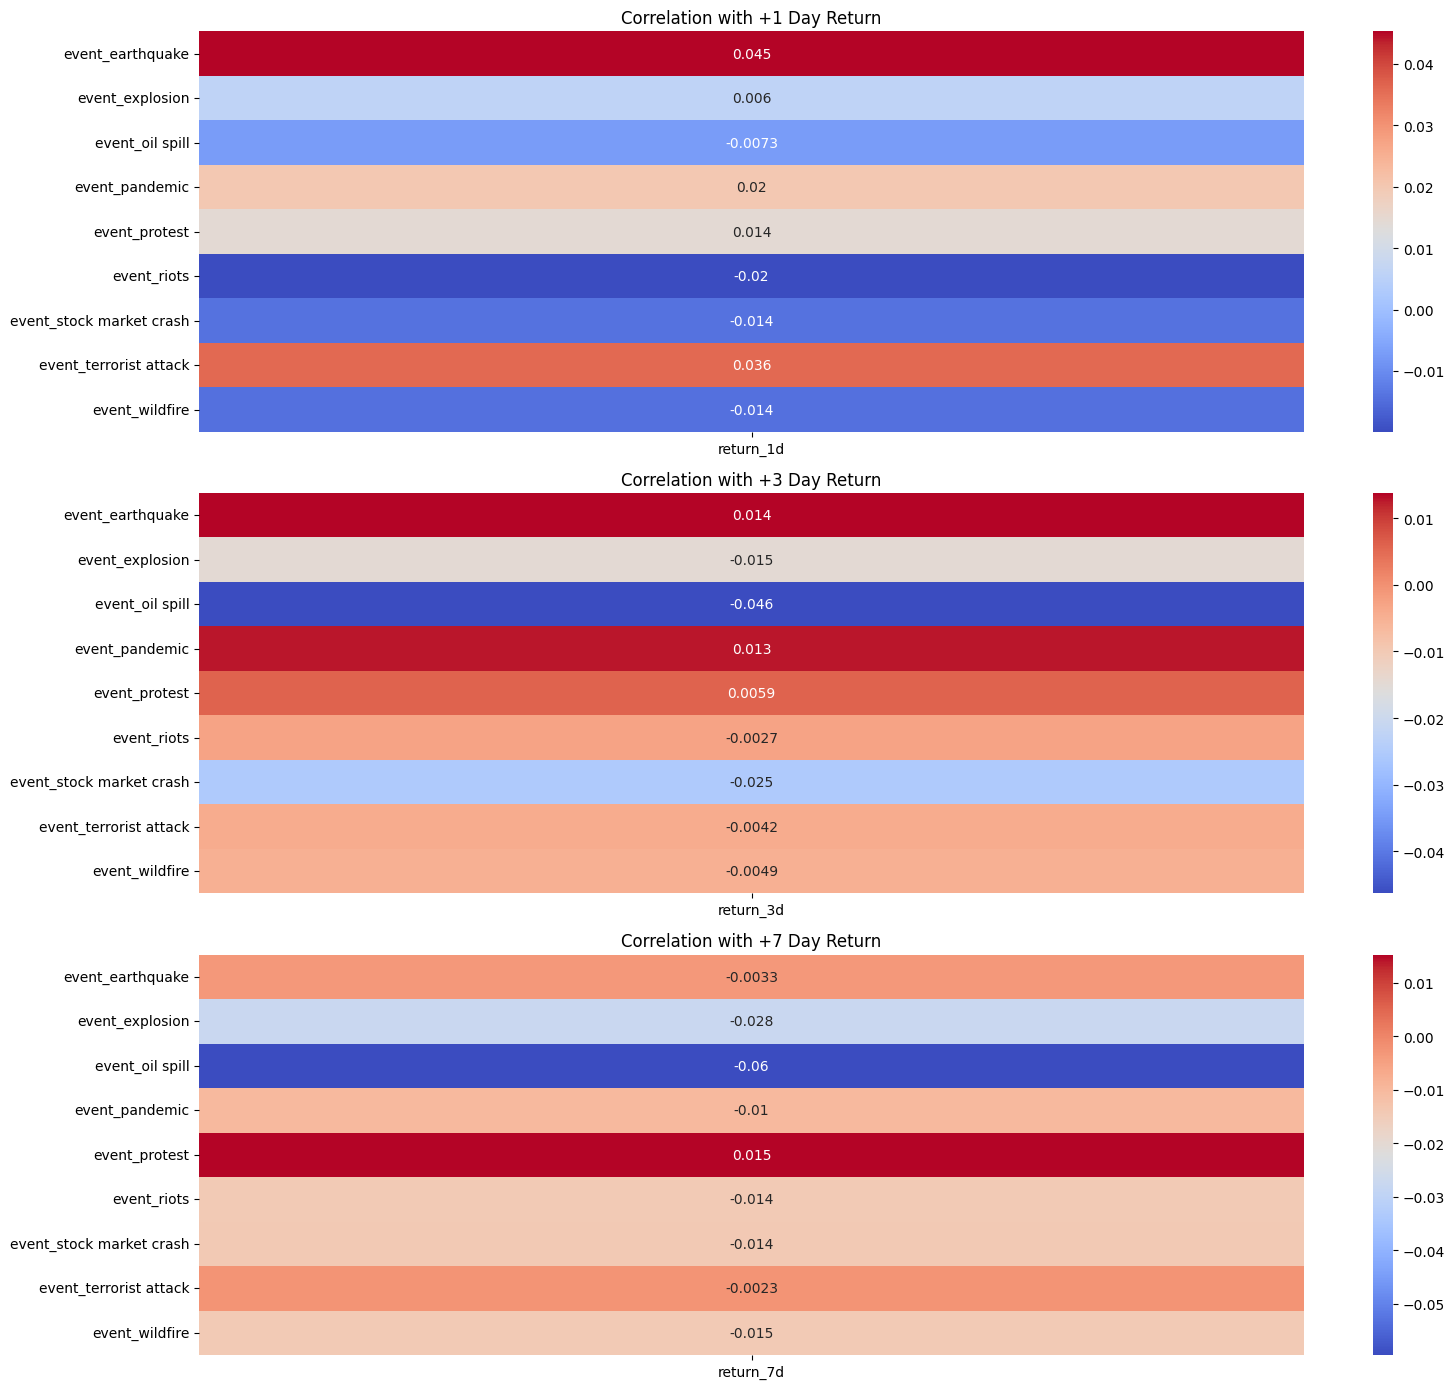

In [16]:

plt.figure(figsize=(16, 14))
plt.subplot(3, 1, 1)
sns.heatmap(cor_1d, annot=True, cmap='coolwarm')
plt.title("Correlation with +1 Day Return")

plt.subplot(3, 1, 2)
sns.heatmap(cor_3d, annot=True, cmap='coolwarm')
plt.title("Correlation with +3 Day Return")

plt.subplot(3, 1, 3)
sns.heatmap(cor_7d, annot=True, cmap='coolwarm')
plt.title("Correlation with +7 Day Return")

plt.tight_layout()
plt.show()

Conclusion: 
It can be observed that directly trying to evaluate a global correlation between disasters and stock prices yields a negligible relation. This can be explained by the fact that stock price movement are often local to the region of disaster. That is, an event in India would have a greater impact on stocks in India rather than US. Further, stock prices typically move as a result of culmination of various societal factors such as community sentiment, company quarterly financial records, trading interest, etc. 

A more detailed correlation is out of the scope of the current project and can be left as a future exercise focusing more on building prediction models for stocks in general instead of trying to find an isolated correlation by a single niche factor.